# Neural Architecture Search (Basic)

In this tutorial we will learn the basis of neural architecture search (NAS). To do so, we will use artificial data generated from a polynomial function. Then, we will discover how to create a search space of neural architecture using a directed graph. Finally, we will see how to define the NAS settings and how to execute the search.

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [1]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

## Loading the data

First, we will create the `load_data` function which loads and returns the
training and validation data. The `load_data` function generates data from
a function $f$ where $\mathbf{x} \in [a, b]^n$  such as $f(\mathbf{x}) = -\sum_{i=0}^{n-1} {x_i ^2}$:

In [2]:
import numpy as np

def load_data(verbose=0, dim=10, a=-50, b=50, prop=0.80, size=10000):
    rs = np.random.RandomState(2018)

    def polynome_2(x):
        return -sum([x_i ** 2 for x_i in x])

    d = b - a
    x = np.array([a + rs.random(dim) * d for _ in range(size)])
    y = np.array([[polynome_2(v)] for v in x])

    sep_index = int(prop * size)
    X_train = x[:sep_index]
    y_train = y[:sep_index]

    X_valid = x[sep_index:]
    y_valid = y[sep_index:]
    
    if verbose:
        print(f"X_train shape: {np.shape(X_train)}")
        print(f"y_train shape: {np.shape(y_train)}")
        print(f"X_valid shape: {np.shape(X_valid)}")
        print(f"y_valid shape: {np.shape(y_valid)}")
    return (X_train, y_train), (X_valid, y_valid)


_ = load_data(verbose=1)

X_train shape: (8000, 10)
y_train shape: (8000, 1)
X_valid shape: (2000, 10)
y_valid shape: (2000, 1)


## Define a neural architecture search space

Then, we will see how to define a space of possible neural architecture.

In [3]:
import collections

import tensorflow as tf

from deephyper.nas.space import KSearchSpace, SpaceFactory
from deephyper.nas.space.node import ConstantNode, VariableNode
from deephyper.nas.space.op import operation
from deephyper.nas.space.op.basic import Zero
from deephyper.nas.space.op.connect import Connect
from deephyper.nas.space.op.merge import AddByProjecting
from deephyper.nas.space.op.op1d import Identity

Activation = operation(tf.keras.layers.Activation)
Dense = operation(tf.keras.layers.Dense)
Dropout = operation(tf.keras.layers.Dropout)
Add = operation(tf.keras.layers.Add)
Flatten = operation(tf.keras.layers.Flatten)

ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]


class ResNetMLPFactory(SpaceFactory):
    def build(
        self,
        input_shape,
        output_shape,
        num_layers=3,
        mode="regression",
        **kwargs,
    ):
        assert mode in ["regression", "classification"]

        self.ss = KSearchSpace(input_shape, output_shape)
        output_dim = output_shape[0]
        source = self.ss.input_nodes[0]

        out_sub_graph = self.build_sub_graph(source, num_layers)

        if mode == "regression":
            output = ConstantNode(op=Dense(output_dim))  # means and stddev
            self.ss.connect(out_sub_graph, output)
        else:
            output = ConstantNode(
                op=Dense(output_dim, activation="softmax")
            )  # One-hot encoding
            self.ss.connect(out_sub_graph, output)

        return self.ss

    def build_sub_graph(self, input_, num_layers=3):
        source = prev_input = input_

        # look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([source], maxlen=3)

        for _ in range(num_layers):
            dense = VariableNode()
            self.add_dense_to_(dense)
            self.ss.connect(prev_input, dense)
            x = dense

            dropout = VariableNode()
            self.add_dropout_to_(dropout)
            self.ss.connect(x, dropout)
            x = dropout

            add = ConstantNode()
            add.set_op(AddByProjecting(self.ss, [x], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self.ss, anchor))
                self.ss.connect(skipco, add)

            prev_input = add

            # ! for next iter
            anchor_points.append(prev_input)

        return prev_input

    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 16 * 16 + 1, 16):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

    def add_dropout_to_(self, node):
        a, b = 1e-3, 0.4
        node.add_op(Identity())
        dropout_range = np.exp(np.linspace(np.log(a), np.log(b), 10))  #! NAS
        for rate in dropout_range:
            node.add_op(Dropout(rate))


def create_search_space(input_shape=(10,), output_shape=(1,), **kwargs):
    return ResNetMLPFactory()(input_shape, output_shape, **kwargs)

Let us visualize a few randomly sampled neural architecture from this search space.

2021-10-14 14:50:24.491686: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


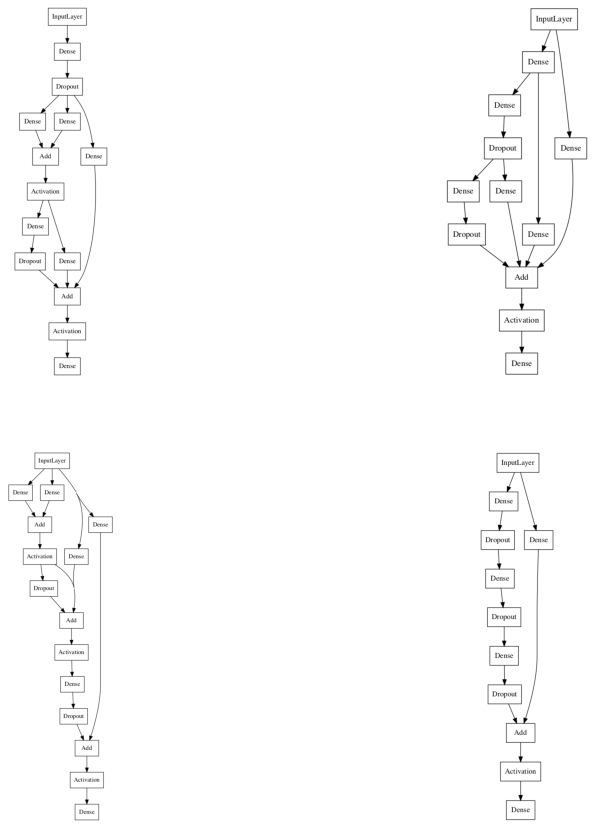

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

shapes = dict(input_shape=(10,), output_shape=(1,))
factory = ResNetMLPFactory()

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    factory.plot_model(**shapes, show_shapes=False, show_layer_names=False) 
    image = mpimg.imread("random_model.png")   
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Create a problem instance

Let us define the neural architecture search problem.

In [5]:
from deephyper.problem import NaProblem
from deephyper.nas.preprocessing import minmaxstdscaler

problem = NaProblem(seed=2019)

problem.load_data(load_data)

problem.preprocessing(minmaxstdscaler)

problem.search_space(create_search_space)

problem.hyperparameters(
    batch_size=32,
    learning_rate=0.01,
    optimizer="adam",
    num_epochs=20,
    callbacks=dict(
        EarlyStopping=dict(
            monitor="val_r2", mode="max", verbose=0, patience=5
        )
    ),
)

problem.loss("mse")

problem.metrics(["r2"])

problem.objective("val_r2__last")

print(problem)

Problem is:
 * SEED = 2019 *
    - search space   : __main__.create_search_space
    - data loading   : __main__.load_data
    - preprocessing  : deephyper.nas.preprocessing.preprocessing.minmaxstdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 32
        * learning_rate: 0.01
        * optimizer: adam
        * num_epochs: 20
        * callbacks: {'EarlyStopping': {'monitor': 'val_r2', 'mode': 'max', 'verbose': 0, 'patience': 5}}
    - loss           : mse
    - metrics        : 
        * r2
    - objective      : val_r2__last



<div class="alert alert-info">
    
<b>Tip</b>
    

Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_r2", mode="max", verbose=0, patience=5)
...
```
    
</div>

We can first train this model to evaluate the baseline accuracy:

## Running the search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function defined previously.

In [6]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.nas.run.alpha import run

evaluator = Evaluator.create(run, 
                 method="ray", 
                 method_kwargs={
                     "address": None, 
                     "num_cpus": 2,
                     "num_cpus_per_task": 1,
                     "callbacks": [LoggerCallback()]
                 })

print("Number of workers: ", evaluator.num_workers)

2021-10-14 14:51:11,745	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


Number of workers:  2


<div class="alert alert-info">
    
<b>Tip</b> 
    
You can open the ray-dashboard at an address like <a>http://127.0.0.1:port</a> in a browser to monitor the CPU usage of the execution.
    
</div>

Finally, you can define a Random search called `Random` and link to it the defined `problem` and `evaluator`.

In [8]:
from deephyper.search.nas import Random

search = Random(problem, evaluator)

In [9]:
results = search.search(10)

(pid=30646) 2021-10-14 14:51:31.202550: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=30646) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=30647) 2021-10-14 14:51:31.205410: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=30647) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=30647) 2021-10-14 14:51:31.806872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
(pid=30646) 2021-10-14 14:51:31.889065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:1

[00001] -- best objective: 0.97581 -- received objective: 0.97581
[00002] -- best objective: 0.97581 -- received objective: 0.92962
[00003] -- best objective: 0.97581 -- received objective: 0.94678
[00004] -- best objective: 0.97581 -- received objective: 0.96561
[00005] -- best objective: 0.97581 -- received objective: 0.95357
[00006] -- best objective: 0.97581 -- received objective: 0.85038
[00007] -- best objective: 0.97581 -- received objective: 0.95892
[00008] -- best objective: 0.97581 -- received objective: 0.95457
[00009] -- best objective: 0.97581 -- received objective: 0.95777
[00010] -- best objective: 0.97581 -- received objective: 0.95610


After the search is over, you will find the following files in your current folder:

```
results.csv
save/
```

Let us visualize the training of our models. First, we need to load the training history of each model which are located in `save/history`:

In [10]:
import os
import json

histories = [os.path.join("save/history", f) for f in os.listdir("save/history/") if ".json" in f]

for i, fpath in enumerate(histories):
    with open(fpath, "r") as fd:
        histories[i] = json.load(fd)
        
print(list(histories[0].keys()))

['n_parameters', 'training_time', 'loss', 'r2', 'val_loss', 'val_r2']


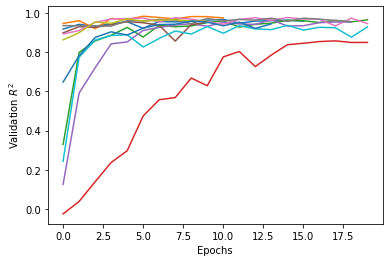

In [11]:
plt.figure()

for h in histories:
    plt.plot(h["val_r2"])

plt.ylabel("Validation $R^2$")
plt.xlabel("Epochs")
plt.show()

Once the search is over, a file named `results.csv` is saved in the current directory. The same dataframe is returned by the `search.search(...)` call. It contains the configurations evaluated during the search and their corresponding `objective` value (i.e, validation accuracy), `duration` of computation and time of computation with `elapsed_sec`. Each neural architecture is embedded as a list of discrete decision variables called `arch_seq`.

In [12]:
results

,arch_seq,id,objective,elapsed_sec,duration
0,"[156, 4, 0, 75, 3, 0, 1, 11, 3, 1, 1, 0]",1,0.975811,26.271427,10.486079
1,"[88, 4, 0, 130, 9, 0, 0, 118, 5, 0, 1, 0]",2,0.929622,29.595276,13.809894
2,"[144, 4, 1, 47, 7, 1, 1, 111, 1, 1, 0, 0]",3,0.946781,34.178133,7.905133
3,"[58, 3, 1, 86, 0, 1, 1, 165, 4, 0, 0, 1]",4,0.965607,37.245527,7.649256
4,"[34, 3, 1, 17, 9, 1, 1, 45, 6, 1, 0, 1]",6,0.953574,40.906715,3.660315
5,"[173, 10, 0, 35, 2, 0, 0, 86, 1, 0, 1, 0]",5,0.850377,41.296332,7.117207
6,"[9, 1, 0, 65, 2, 1, 0, 62, 4, 1, 0, 0]",7,0.958918,45.566326,4.658723
7,"[95, 0, 1, 33, 9, 1, 0, 134, 8, 1, 1, 1]",8,0.954567,48.384888,7.087777
8,"[110, 9, 1, 70, 0, 0, 1, 68, 2, 1, 0, 1]",9,0.957768,49.524877,3.957820
9,"[49, 0, 1, 20, 10, 0, 1, 105, 5, 1, 0, 1]",10,0.956096,54.579785,6.194027


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [13]:
!deephyper-analytics topk results.csv -k 3

'0':
  arch_seq: '[156, 4, 0, 75, 3, 0, 1, 11, 3, 1, 1, 0]'
  duration: 10.4860789776
  elapsed_sec: 26.2714271545
  id: 1
  objective: 0.9758111835
'1':
  arch_seq: '[58, 3, 1, 86, 0, 1, 1, 165, 4, 0, 0, 1]'
  duration: 7.649255991
  elapsed_sec: 37.2455272675
  id: 4
  objective: 0.9656074643
'2':
  arch_seq: '[9, 1, 0, 65, 2, 1, 0, 62, 4, 1, 0, 0]'
  duration: 4.6587228775
  elapsed_sec: 45.5663261414
  id: 7
  objective: 0.9589181542



Where each architecture is described as a vector of scalar values named arch_seq. In fact, each of this scalar values represents chosen operations for the variable nodes of our search space. 

## Testing the best configuration

We can visualize the architecture of the best configuration:

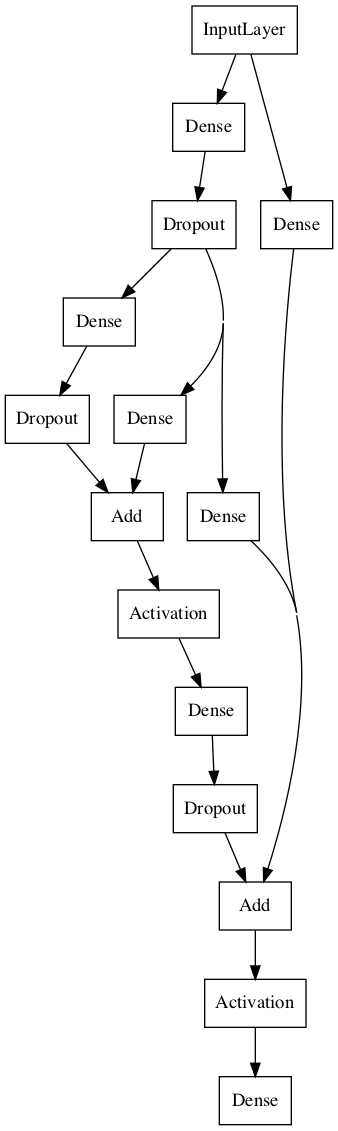

In [14]:
best_config = results.iloc[results.objective.argmax()][:-2].to_dict()
arch_seq = json.loads(best_config["arch_seq"])
factory.plot_model(**shapes, ops=arch_seq, show_shapes=False, show_layer_names=False) 